#### Extraction code logic for all Shapefile Files

In [21]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
from scipy import sparse
import random
import os
from sys import getsizeof
from shapely.geometry import Polygon
from shapely import Point
from shapely.geometry import MultiPoint
from shapely import ops

coords = json.load(open('../Extract/coords.json'))
mpl.rcParams['figure.dpi'] = 120
# mpl.rcParams['savefig.pad_inches'] = 0

random.seed(10) # SO WE GET THE SAME DATASET EVERY TIME

# This code is processed 
# I have manually processed every file using this format

directory = r"D:\Users\xubil\OneDrive\Documents\Wildfires Data NPZ\Training"
data = {}

In [3]:
target_limit =  "limits_4326" #"limits_testing_9_chunks"
xmin, xmax, ymin, ymax = (coords[target_limit]["xmin"]), (coords[target_limit]["xmax"]), (coords[target_limit]["ymin"]), (coords[target_limit]["ymax"])

'''
where new_image is a figure.canvas.buffer_rgba() turned into a np matrix: 

nonzero_rows, nonzero_cols = np.nonzero(new_image) # Get all nonzero rows & collumns 

min_row, max_row = np.min(nonzero_rows), np.max(nonzero_rows)
min_col, max_col = np.min(nonzero_cols), np.max(nonzero_cols)
# After a series of test, (0, 575, 3, 764) was the exact fit of the canvas when the ration between width:height = 2:1

'''

min_row, max_row, min_col, max_col = 0, 575, 3, 764 
xyratio = 2/1

resx = 0.2
resy = resx/xyratio
n_chunkx = int(round((xmax-xmin)/resx, 1)) # MAKE SURE YOU CAN MATH: because we convert to int if you get 0.1232131 sketch 
n_chunky = int(round((ymax-ymin)/resy, 1)) # We're using round to not get like 2.9999999999999999997 make sure to get 0.3

# For Final Extraction: 
# x: 19.8/99 = 0.2 per chunk for 99 chunks
# y: 8/80 = 0.1 per chunk for 80 chunks

# For this file more specifically, we want to process an area around the point. Let us use the size of a chunk: 0.05 by 0.05
mat_l = 0.05

In [4]:
gdf = gpd.read_file(r"D:\Users\xubil\OneDrive\Documents\Wildfires Data\Feux_pt_ori_SHP\FEUX_PT_ORI_1972_2022.shp") # Path to the shapefile 

In [5]:
causes = ["Humaine", "Foudre"]
gdf = gdf.to_crs(4326)

In [6]:
gdf

OBJECTID          CLE  ANNEE  NOFEU    SECTION    CAUSE  DATE_DEBUT  \
0             1  20221080001   2022      1  Intensive  Humaine  2022-04-06   
1             2  20221080002   2022      2  Intensive  Humaine  2022-04-12   
2             3  20221080003   2022      3  Intensive  Humaine  2022-04-12   
3             4  20221080004   2022      4  Intensive  Humaine  2022-04-12   
4             5  20221080005   2022      5  Intensive  Humaine  2022-04-18   
...         ...          ...    ...    ...        ...      ...         ...   
43235         0  20211080621   2021    621  Intensive  Humaine  2021-10-28   
43236         0  20211080622   2021    622  Intensive  Humaine  2021-11-09   
43237         0  20211080623   2021    623  Intensive  Humaine  2021-11-11   
43238         0  20211080624   2021    624  Intensive  Humaine  2021-11-10   
43239         0  20211080625   2021    625  Intensive  Humaine  2021-11-12   

       DATE_RAPPO  DATE_ETEIN  SUP_HA  LATITUDE  LONGITUDE  \
0      2022-04-06  2022-04-06     0.4   45.1289   -72.1135   
1      2022-04-12  2022-04-12     0.5   45.6624   -74.3352   
2      2022-04-12  2022-04-12     0.0   45.6734   -74.3641   
3      2022-04-12  2022-04-12     0.6   45.9701   -77.1305   
4      2022-04-18  2022-04-18     0.4   45.7227   -74.3818   
...           ...         ...     ...       ...        ...   
43235  2021-10-28  2021-10-28     0.0   45.4606   -72.1554   
43236  2021-11-09  2021-11-11     2.0   45.9512   -75.8547   
43237  2021-11-11  2021-11-11     0.0   45.9812   -74.2104   
43238  2021-11-16  2021-11-16     0.0   45.3931   -72.1209   
43239  2021-11-12  2021-11-12     0.0   45.0850   -72.5975   

                         geometry  
0      POINT (-72.11350 45.12890)  
1      POINT (-74.33520 45.66240)  
2      POINT (-74.36410 45.67340)  
3      POINT (-77.13050 45.97010)  
4      POINT (-74.38180 45.72270)  
...                           ...  
43235  POINT (-72.15540 45.46060)  
43236  POINT (-75.85470 45.95120)  
43237  POINT (-74.21040 45.98120)  
43238  POINT (-72.12090 45.39310)  
43239  POINT (-72.59750 45.08500)  

[43240 rows x 13 columns]

In [7]:
gdf[gdf["CAUSE"] == "Foudre"].shape

(11908, 13)

### Process Training Data

In [8]:
count = 0

random.seed(10) # MAKE SURE WE GET THE SAME BOUNDS EVERY TIME :))

for cause in causes:
    print(cause)
    trainingInputCoords = []

    for point in gdf[gdf["CAUSE"] == cause].iterrows():
        rand = random.random() # Set seed makes the dataset generated always the same <3
        # rand 0-1 number determines the where exactly the grid cropped (only if possible if we are at bounds it will auto-adjust to fit bounds)

        # # # # # # # # #^
        #               #✓ The length of height and width offset is the same!!! 
        #    P          #
        #               #     
        #               #
        #               #
        # # # # # # # # #
        #<->

        # print(point)
        # print(count)

        rxcoord, rycoord = point[1]["geometry"].bounds[0], point[1]["geometry"].bounds[1]

        # print(rxcoord, rycoord)

        if not (rxcoord >= xmin and rxcoord <= xmax and rycoord >= ymin and rycoord <= ymax):
            continue

        # print(xcoord, ycoord)

        min_x, min_y = round(rxcoord-int(rand*mat_l), 3), round(rycoord-int(rand*mat_l), 3)
        max_x, max_y = min_x+mat_l, min_y+mat_l

        # print(min_x, max_x, min_y, max_y)

        # Shift the square if it is out of boundsss 
        if (min_x < xmin):
            min_x = xmin
            max_x = xmin+mat_l
        if (min_y < ymin):
            min_y = ymin
            max_y = ymin+mat_l
        if (max_x > xmax):
            max_x = xmax
            min_x = xmax-mat_l
        if (max_y >= ymax):
            max_y = ymax-1
            min_y = ymax-mat_l
        
        trainingInputCoords.append((min_x, max_x, min_y, max_y))

        print(min_x, max_x, min_y, max_y)

        count+=1

        # if (count > 100):
        #     break
        # count+=1
    # break
    np.save('../data-training/'+cause, trainingInputCoords)
    del trainingInputCoords

    # break

Humaine
-72.113 -72.063 45.129 45.178999999999995
-74.335 -74.285 45.662 45.711999999999996
-74.364 -74.31400000000001 45.673 45.723
-77.13 -77.08 45.97 46.019999999999996
-74.382 -74.33200000000001 45.723 45.772999999999996
-74.41 -74.36 45.668 45.717999999999996
-72.791 -72.741 45.319 45.369
-73.1 -73.05 46.003 46.053
-77.89 -77.84 48.23 48.279999999999994
-74.467 -74.417 45.928 45.977999999999994
-74.485 -74.435 45.628 45.678
-72.69 -72.64 45.708 45.757999999999996
-72.288 -72.238 45.173 45.223
-73.561 -73.51100000000001 46.328 46.378
-72.273 -72.223 46.129 46.178999999999995
-72.034 -71.98400000000001 46.913 46.962999999999994
-72.713 -72.663 46.466 46.516
-73.422 -73.372 45.887 45.937
-72.288 -72.238 46.523 46.573
-76.433 -76.38300000000001 45.875 45.925
-76.113 -76.063 46.0 46.05
-72.744 -72.694 46.319 46.369
-79.095 -79.045 46.717 46.766999999999996
-72.937 -72.887 47.038 47.087999999999994
-79.52 -79.47 47.369 47.419
-74.12 -74.07000000000001 45.799 45.849
-74.876 -74.826000000

### Similarly, we can create a code to generate training data where no fire events occured

In [27]:
def pointInRect(point,rect):
    x1, y1, x2, y2 = rect
    # x2, y2 = x1+w, y1+h
    x, y = point
    if (x1 < x and x < x2):
        if (y1 < y and y < y2):
            return True
    return False

In [17]:
points = []

for point in gdf.iterrows():
    checkx, checky = point[1]["geometry"].bounds[0], point[1]["geometry"].bounds[1]
    points.append([checkx, checky])

In [22]:
ob = MultiPoint(points)

In [33]:
ob.intersects(poly)

True

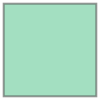

In [31]:
poly

In [35]:
count = 0

random.seed(11) # MAKE SURE WE GET THE SAME BOUNDS EVERY TIME :))
trainingInputCoords = []

for i in range(42000): # About the same number of entries as Humaine and Foudre combined

    movingOn = False
    
    while(not movingOn):
        rand = random.random() 

        rxcoord, rycoord = (random.random()*(xmax-xmin)+xmin), (random.random()*(ymax-ymin)+ymin) # Generate two points between the bounds

        min_x, min_y = round(rxcoord-int(rand*mat_l), 3), round(rycoord-int(rand*mat_l), 3)
        max_x, max_y = min_x+mat_l, min_y+mat_l


        # Shift the square if it is out of boundsss 
        if (min_x < xmin):
            min_x = xmin
            max_x = xmin+mat_l
        if (min_y < ymin):
            min_y = ymin
            max_y = ymin+mat_l
        if (max_x > xmax):
            max_x = xmax
            min_x = xmax-mat_l
        if (max_y >= ymax):
            max_y = ymax-1
            min_y = ymax-mat_l

        poly = Polygon([[min_x, min_y], [min_x, max_y], [max_x, max_y], [max_x, min_y]])

        # print(gdf.bounds)


        if (poly.intersects(ob)):
            print("Contains Point!")
        else:
            # print("Doesn't Contain!")
            movingOn = True
        
        # for point in gdf.iterrows():
        #     checkx, checky = point[1]["geometry"].bounds[0], point[1]["geometry"].bounds[1]
        #     if not pointInRect((checkx, checky), (min_x, max_x, min_y, max_y)):
        #         movingOn = True
            
    trainingInputCoords.append((min_x, max_x, min_y, max_y))

    # print(min_x, max_x, min_y, max_y)

    # if count == 0:
    #     break

    count+=1
    print(count)

np.save('../data-training/Sans-Feu', trainingInputCoords)
del trainingInputCoords

Contains Point!
1
2
Contains Point!
3
4
5
6
7
8
9
10
11
Contains Point!
12
13
14
15
Contains Point!
16
17
Contains Point!
18
19
20
Contains Point!
21
22
23
24
25
26
27
28
29
Contains Point!
30
31
32
Contains Point!
33
34
Contains Point!
35
36
37
38
39
40
41
42
43
44
45
46
47
48
Contains Point!
49
50
Contains Point!
51
52
53
54
55
Contains Point!
56
57
Contains Point!
58
59
60
61
Contains Point!
62
63
Contains Point!
64
65
66
67
68
69
70
71
72
73
Contains Point!
74
Contains Point!
75
76
77
78
79
80
81
Contains Point!
82
83
84
Contains Point!
85
86
87
Contains Point!
88
89
90
Contains Point!
Contains Point!
91
92
93
94
95
96
Contains Point!
Contains Point!
Contains Point!
97
Contains Point!
98
Contains Point!
99
100
101
102
103
104
105
Contains Point!
106
107
108
109
Contains Point!
Contains Point!
110
Contains Point!
111
Contains Point!
112
113
114
115
116
117
118
119
Contains Point!
Contains Point!
120
121
122
123
124
Contains Point!
125
126
127
128
129
Contains Point!
130
131
132
Cont

### And one more time for Data with Temporal Data

In [9]:
count = 0

random.seed(11) # MAKE SURE WE GET THE SAME BOUNDS EVERY TIME :))
trainingInputCoords = []

for i in range(42000): # About the same number of entries as Humaine and Foudre combined

    movingOn = False
    
    rand = random.random() 

    rxcoord, rycoord = (random.random()*(xmax-xmin)+xmin), (random.random()*(ymax-ymin)+ymin) # Generate two points between the bounds

    min_x, min_y = round(rxcoord-int(rand*mat_l), 3), round(rycoord-int(rand*mat_l), 3)
    max_x, max_y = min_x+mat_l, min_y+mat_l


        # Shift the square if it is out of boundsss 
    if (min_x < xmin):
        min_x = xmin
        max_x = xmin+mat_l
    if (min_y < ymin):
        min_y = ymin
        max_y = ymin+mat_l
    if (max_x > xmax):
        max_x = xmax
        min_x = xmax-mat_l
    if (max_y >= ymax):
        max_y = ymax-1
        min_y = ymax-mat_l     
            
    trainingInputCoords.append((min_x, max_x, min_y, max_y))

    print(min_x, max_x, min_y, max_y)

    count+=1

np.save('../data-training/Sans-Feu-Temp', trainingInputCoords)
del trainingInputCoords

-69.317 -69.267 51.994 52.044
-70.345 -70.295 49.299 49.349
-70.264 -70.214 49.639 49.689
-78.536 -78.486 47.027 47.077
-64.369 -64.319 50.148 50.198
-60.953 -60.903000000000006 52.318 52.367999999999995
-68.212 -68.162 45.86 45.91
-69.938 -69.888 45.076 45.126
-75.61 -75.56 44.841 44.891
-71.677 -71.62700000000001 51.339 51.388999999999996
-67.722 -67.672 48.598 48.647999999999996
-71.345 -71.295 46.825 46.875
-60.685 -60.635000000000005 51.322 51.372
-74.158 -74.108 46.437 46.486999999999995
-79.01 -78.96000000000001 50.73 50.779999999999994
-63.638 -63.588 47.692 47.742
-63.623 -63.573 44.604 44.653999999999996
-62.377 -62.327000000000005 48.36 48.41
-72.531 -72.48100000000001 45.184 45.233999999999995
-64.985 -64.935 46.758 46.808
-73.815 -73.765 52.313 52.363
-78.064 -78.014 46.571 46.620999999999995
-79.214 -79.164 50.976 51.025999999999996
-69.326 -69.276 48.179 48.229
-65.908 -65.858 45.648 45.698
-78.093 -78.043 47.966 48.016
-75.058 -75.00800000000001 52.367 52.41699999999999